# Objective
1. Split a training set into a smaller training set and a validation set
2. Analyze deltas between training set and validation results
3. Test the trained model with a test set to determine whether the model is overfitting
4. Detect and fix a common training problem

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

2022-10-19 08:33:14.788767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 08:33:14.863274: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-19 08:33:14.866450: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-19 08:33:14.866457: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

## Load dataset

In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")


## Scale the label values

In [3]:
scale_factor = 1000.0

train_df["median_house_value"] /= scale_factor

test_df["median_house_value"] /= scale_factor

## Define build and train model

In [4]:
def build_model(my_learning_rate):
    
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))
    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                 loss="mean_squared_error",
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model


def train_model(model, df, feature, label, my_epochs,
               my_batch_size=None, my_validation_split=0.1):
    
    history = model.fit(x=df[feature],
                       y=df[label],
                       batch_size=my_batch_size,
                       epochs=my_epochs,
                       validation_split=my_validation_split)
    
    trained_weight = model.get_weights()[0]
    trained_bias = model.get_weights()[1]
    
    epochs = history.epoch
    
    hist = pd.DataFrame(history.history)
    rmse = hist["root_mean_squared_error"]
    
    return epochs, rmse, history.history

print("Defined build_model and train_model functions")

Defined build_model and train_model functions


## Define plotting function

In [5]:
def plot_the_loss_curve(epochs, mae_training, mae_validation):
    
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")
    
    plt.plot(epochs[1:], mae_training[1:], label="Training Loss")
    plt.plot(epochs[1:], mae_validation[1:], label="Validation Loss")
    plt.legend()
    
    #We are not going to plot the first epoch, since the loss on the first epoch
    #is often substantially greater than the loss for other projects
    merged_mae_lists = mae_training[1:] + mae_validation[1:]
    highest_loss = max(merged_mae_lists)
    lowest_loss = min(merged_mae_lists)
    delta = highest_loss - lowest_loss
    print(delta)
    
    top_of_y_axis = highest_loss + (delta * 0.05)
    bottom_of_y_axis = lowest_loss - (delta * 0.05)
    
    plt.ylim([bottom_of_y_axis, top_of_y_axis])
    plt.show()
    
print("Defined the plot_the_loss_curve function")

Defined the plot_the_loss_curve function


## Experiment with validation split

Epoch 1/30


2022-10-19 08:33:30.942453: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-19 08:33:30.942475: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-19 08:33:30.942491: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nsl54): /proc/driver/nvidia/version does not exist
2022-10-19 08:33:30.942696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/nsl54/anaconda3/envs/mlenv/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmspr

136/136 [==============================] - 0s 1ms/step - loss: 40497.8398 - root_mean_squared_error: 201.2407 - val_loss: 49110.4180 - val_root_mean_squared_error: 221.6087
Epoch 2/30
136/136 [==============================] - 0s 640us/step - loss: 23393.0938 - root_mean_squared_error: 152.9480 - val_loss: 28787.6230 - val_root_mean_squared_error: 169.6692
Epoch 3/30
136/136 [==============================] - 0s 622us/step - loss: 12438.7910 - root_mean_squared_error: 111.5293 - val_loss: 15635.3457 - val_root_mean_squared_error: 125.0414
Epoch 4/30
136/136 [==============================] - 0s 603us/step - loss: 7346.5498 - root_mean_squared_error: 85.7120 - val_loss: 9834.2656 - val_root_mean_squared_error: 99.1679
Epoch 5/30
136/136 [==============================] - 0s 606us/step - loss: 6517.4580 - root_mean_squared_error: 80.7308 - val_loss: 9213.2109 - val_root_mean_squared_error: 95.9855
Epoch 6/30
136/136 [==============================] - 0s 611us/step - loss: 6514.2622 - roo

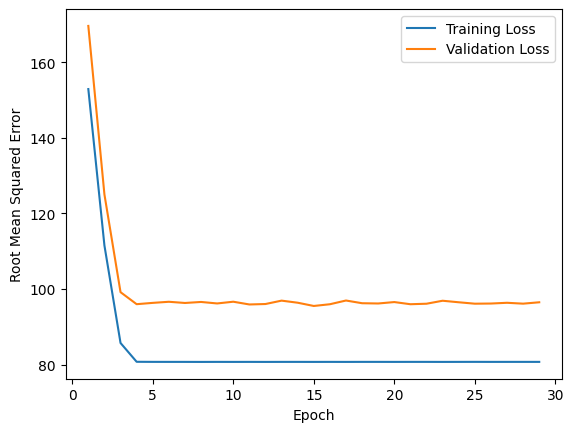

In [6]:
learning_rate = 0.08
epochs = 30
batch_size = 100

#split original training set into a reduced training set and a validation set
validation_split = 0.2

my_feature = "median_income"
my_label = "median_house_value"

my_model = build_model(learning_rate)
epochs, rmse, history = train_model(my_model, train_df, my_feature,
                                   my_label, epochs, batch_size,
                                   validation_split)

plot_the_loss_curve(epochs, history["root_mean_squared_error"],
                   history["val_root_mean_squared_error"])

The original training set contains 17,000 examples.
validation_split of 0.2 means that:
- 17,000 * 0.2 ~= 3,400 examples will become the validation set
- 17,000 * 0.8 ~= 13,600 examples will become the new training set



In [30]:
train_df.head(n=13000)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66.9
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80.1
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85.7
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73.4
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65.5
...,...,...,...,...,...,...,...,...,...
12995,-121.8,37.3,16.0,2987.0,874.0,4241.0,841.0,2.8,127.9
12996,-121.8,37.3,19.0,6275.0,1546.0,4312.0,1466.0,2.8,178.6
12997,-121.8,37.3,17.0,4208.0,954.0,1476.0,904.0,2.4,87.5
12998,-121.8,37.3,17.0,1957.0,261.0,863.0,269.0,7.3,294.2


## Fix the problem that causes the curves to differ this much
The above DataFrame shows that the longitude throughout the training set differs heavily from the start to the end. Since the training set is sorted by longitude, this heavily influences the result. We can shuffle the examples to fix this problem and observe the new result:

Epoch 1/30
  1/136 [..............................] - ETA: 17s - loss: 54966.0039 - root_mean_squared_error: 234.4483

/home/nsl54/anaconda3/envs/mlenv/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/nsl54/anaconda3/envs/mlenv/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


136/136 [==============================] - 0s 1ms/step - loss: 42234.6484 - root_mean_squared_error: 205.5107 - val_loss: 31613.1875 - val_root_mean_squared_error: 177.8010
Epoch 2/30
136/136 [==============================] - 0s 615us/step - loss: 24517.4961 - root_mean_squared_error: 156.5806 - val_loss: 17294.0605 - val_root_mean_squared_error: 131.5069
Epoch 3/30
136/136 [==============================] - 0s 614us/step - loss: 13188.0557 - root_mean_squared_error: 114.8393 - val_loss: 9164.5527 - val_root_mean_squared_error: 95.7317
Epoch 4/30
136/136 [==============================] - 0s 620us/step - loss: 7885.2510 - root_mean_squared_error: 88.7989 - val_loss: 6833.9990 - val_root_mean_squared_error: 82.6680
Epoch 5/30
136/136 [==============================] - 0s 603us/step - loss: 7071.3687 - root_mean_squared_error: 84.0914 - val_loss: 6809.7007 - val_root_mean_squared_error: 82.5209
Epoch 6/30
136/136 [==============================] - 0s 605us/step - loss: 7067.5513 - root_

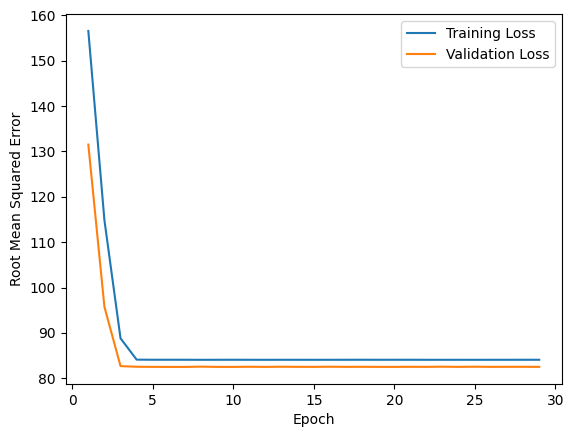

In [37]:
learning_rate = 0.08
epochs = 30
batch_size = 100

#split original training set into a reduced training set and a validation set
validation_split = 0.2


my_feature = "median_income"
my_label = "median_house_value"

my_model = build_model(learning_rate)
shuffled_train_df = train_df.reindex(np.random.permutation(train_df.index)) #shuffles the example set data
epochs, rmse, history = train_model(my_model, shuffled_train_df, my_feature,
                                   my_label, epochs, batch_size,
                                   validation_split)

plot_the_loss_curve(epochs, history["root_mean_squared_error"],
                   history["val_root_mean_squared_error"])

After shuffling the original training set, the final loss for training set and validation set become much closer. If validation split < 0.15, the validation set no longer contains enough examples and the final loss values for the training set and the validation set diverge.

## Use the test dataset to evaluate the model's performance

In [38]:
x_test = test_df[my_feature]
y_test = test_df[my_label]

results = my_model.evaluate(x_test, y_test, batch_size=batch_size)

30/30 [==============================] - 0s 538us/step - loss: 7009.2251 - root_mean_squared_error: 83.7211


final validation error = 82.4998 <br>
test data error = 83.7211